In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt

# CONSTANTS

STEP_REWARD = -1
TREASURE_REWARD = 30
EXIT_REWARD = 100
HAZARD_REWARD = -50

GAMMA = 0.9
THETA = 0.1

In [ ]:
# REGIONS
JUNGLE, CAVE, CLIFF, BEACH, VILLAGE = range(5)
REGION_NAMES = {
    JUNGLE: "JUNGLE",
    CAVE: "CAVE",
    CLIFF: "CLIFF",
    BEACH: "BEACH",
    VILLAGE: "VILLAGE"
}

In [ ]:
# ENVIRONMENT SETUP
def create_region_grid(size):
    grid = np.zeros((size, size), dtype=int)
    for x in range(size):
        for y in range(size):
            if x < size//2 and y < size//2:
                grid[x, y] = JUNGLE
            elif x < size//2:
                grid[x, y] = CAVE
            elif y < size//2:
                grid[x, y] = CLIFF
            else:
                grid[x, y] = BEACH
    grid[size-2:size, size-2:size] = VILLAGE
    return grid

def create_treasures(region_grid, num=5):
    size = region_grid.shape[0]
    treasures = []
    for r in [JUNGLE, CAVE]:
        cells = [(x,y) for x in range(size) for y in range(size)
                 if region_grid[x,y] == r]
        treasures.append(list(cells[len(cells)//2]))
    treasures.append([size//2, size//2])
    treasures.append([size//2-1, size//2])
    return treasures[:num]

In [ ]:
# ACTIONS & STOCHASTIC TRANSITIONS
MOVES = [(-1,0),(0,1),(1,0),(0,-1)]  # N, E, S, W

# 70% intended, 7.5% left, 7.5% right, 15% stay
ACTION_PROBS = [
    (0.7, 0),
    (0.075, -1),
    (0.075, 1)
]
STAY_PROB = 0.15

def apply_action(x, y, action, SIZE):
    dx, dy = MOVES[action]
    nx, ny = x + dx, y + dy
    if nx < 0 or nx >= SIZE or ny < 0 or ny >= SIZE:
        return x, y
    return nx, ny

def stochastic_transitions(state, action, treasures, SIZE):
    x, y, mask = state
    transitions = []

    for prob, shift in ACTION_PROBS:
        a = (action + shift) % 4
        nx, ny = apply_action(x, y, a, SIZE)
        nmask = mask
        for i, t in enumerate(treasures):
            if [nx, ny] == t:
                nmask |= (1 << i)
        transitions.append((prob, (nx, ny, nmask)))

    transitions.append((STAY_PROB, (x, y, mask)))
    return transitions

In [ ]:
# REWARD FUNCTION
def get_reward(state, next_state, obstacles, end, treasures):
    reward = STEP_REWARD
    x, y, mask = next_state
    _, _, prev_mask = state

    if [x, y] in obstacles:
        reward += HAZARD_REWARD
    if mask != prev_mask:
        reward += TREASURE_REWARD
    if [x, y] == end and mask == (1 << len(treasures)) - 1:
        reward += EXIT_REWARD
    return reward

In [ ]:
# VALUE ITERATION (EXPECTED VALUE)
def value_iteration(SIZE, obstacles, end, treasures):
    T = 1 << len(treasures)
    U = np.zeros((SIZE, SIZE, T))
    policy = np.zeros((SIZE, SIZE, T), dtype=int)

    while True:
        delta = 0
        newU = U.copy()

        for x in range(SIZE):
            for y in range(SIZE):
                for mask in range(T):
                    state = (x, y, mask)
                    best_val = -1e9
                    best_a = 0

                    for a in range(4):
                        val = 0
                        for p, ns in stochastic_transitions(state, a, treasures, SIZE):
                            r = get_reward(state, ns, obstacles, end, treasures)
                            nx, ny, nm = ns
                            val += p * (r + GAMMA * U[nx, ny, nm])

                        if val > best_val:
                            best_val = val
                            best_a = a

                    newU[x, y, mask] = best_val
                    policy[x, y, mask] = best_a
                    delta = max(delta, abs(best_val - U[x, y, mask]))

        U = newU
        if delta < THETA:
            break

    return policy

In [ ]:
# OPTIONS (HIERARCHICAL MDP)
class Option:
    def initiation(self, state): pass
    def policy(self, state): pass
    def termination(self, state): pass

class NavigateToRegion(Option):
    def __init__(self, region, region_grid, flat_policy):
        self.region = region
        self.grid = region_grid
        self.flat_policy = flat_policy

    def initiation(self, state):
        x, y, _ = state
        return self.grid[x, y] != self.region

    def policy(self, state):
        return self.flat_policy[state]

    def termination(self, state):
        x, y, _ = state
        return self.grid[x, y] == self.region

class CollectTreasure(Option):
    def __init__(self, treasures, flat_policy):
        self.treasures = treasures
        self.flat_policy = flat_policy

    def initiation(self, state):
        return True

    def policy(self, state):
        return self.flat_policy[state]

    def termination(self, state):
        return state[2] == (1 << len(self.treasures)) - 1

class GoToExit(Option):
    def __init__(self, end, treasures, flat_policy):
        self.end = end
        self.treasures = treasures
        self.flat_policy = flat_policy

    def initiation(self, state):
        return state[2] == (1 << len(self.treasures)) - 1

    def policy(self, state):
        return self.flat_policy[state]

    def termination(self, state):
        x, y, _ = state
        return [x, y] == self.end

class HierarchicalAgent:
    def __init__(self, options):
        self.options = options
        self.current = None

    def act(self, state):
        if self.current is None or self.current.termination(state):
            for opt in self.options:
                if opt.initiation(state):
                    self.current = opt
                    break
        return self.current.policy(state)


In [ ]:
# VISUALIZATION
def draw_grid(region_grid, treasures, obstacles, end, pos):
    plt.imshow(region_grid, cmap="tab20")
    for t in treasures:
        plt.scatter(t[1], t[0], c="gold", s=120, marker="*")
    for o in obstacles:
        plt.scatter(o[1], o[0], c="black", s=50)
    plt.scatter(end[1], end[0], c="blue", s=100, marker="s")
    plt.scatter(pos[1], pos[0], c="red", s=100)
    plt.xticks([]); plt.yticks([])
    plt.pause(0.25)
    plt.clf()

In [ ]:
# SIMULATION
def run_episode(agent_type, start, end, treasures, obstacles,
                flat_policy=None, hier_agent=None, visualize=False):

    pos = start
    steps, reward = 0, 0
    start_time = time.perf_counter()

    while not ([pos[0], pos[1]] == end and
               pos[2] == (1 << len(treasures)) - 1):

        action = flat_policy[pos] if agent_type == "flat" else hier_agent.act(pos)

        transitions = stochastic_transitions(pos, action, treasures, SIZE)
        probs = np.array([p for p, _ in transitions])
        probs /= probs.sum()  # safety normalization
        states = [s for _, s in transitions]

        next_pos = states[np.random.choice(len(states), p=probs)]

        reward += get_reward(pos, next_pos, obstacles, end, treasures)
        pos = next_pos
        steps += 1

        if visualize:
            draw_grid(region_grid, treasures, obstacles, END, pos)

    return steps, reward, time.perf_counter() - start_time

Running Value Iteration...

=== PERFORMANCE COMPARISON ===
Flat MDP         -> Steps:70 Reward:50 Time:0.0046s
Hierarchical MDP -> Steps:66 Reward:104 Time:0.0046s

Visualizing Hierarchical Agent...


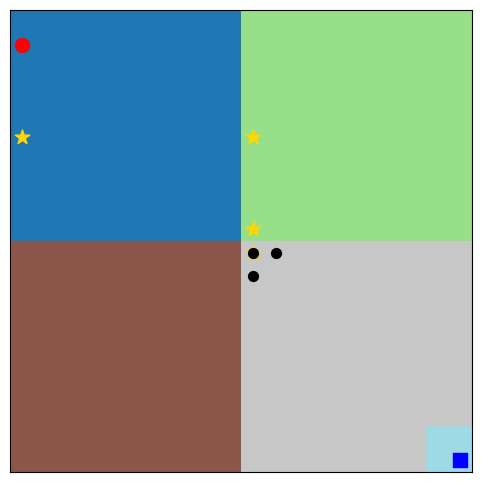

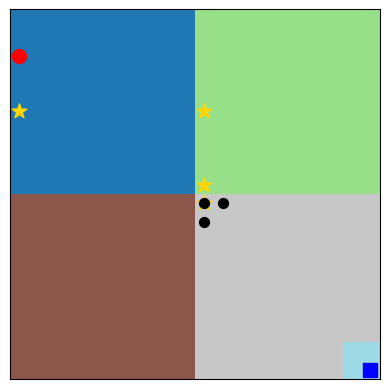

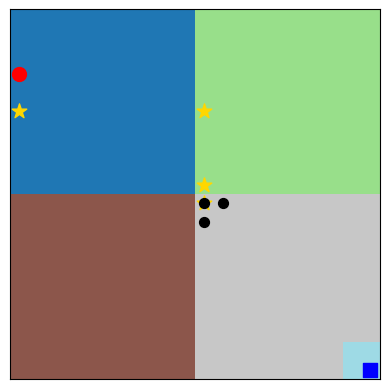

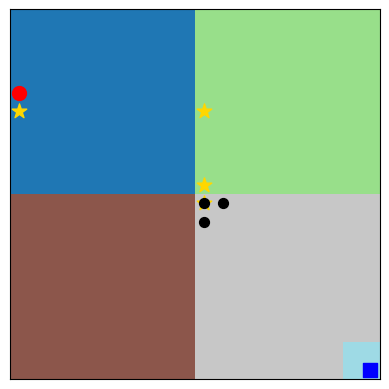

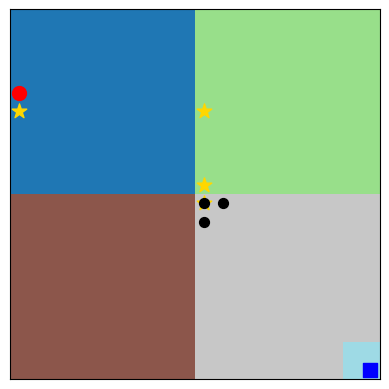

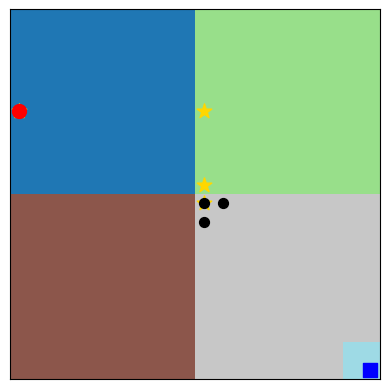

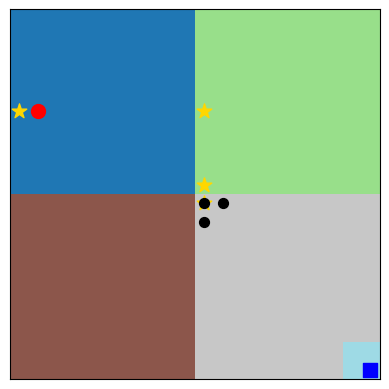

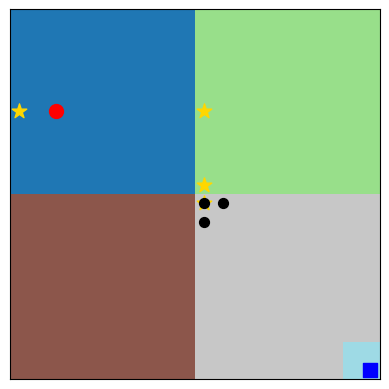

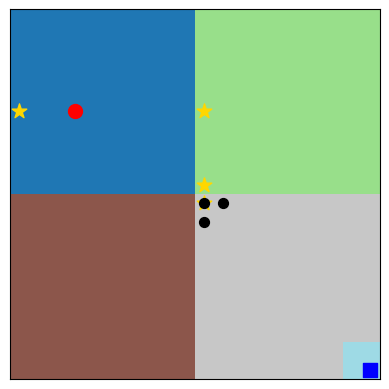

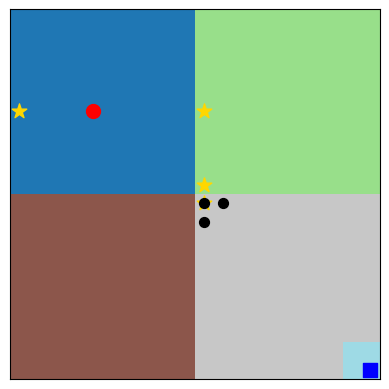

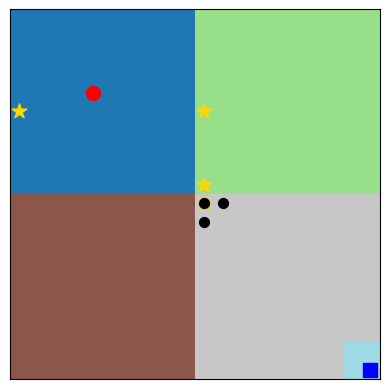

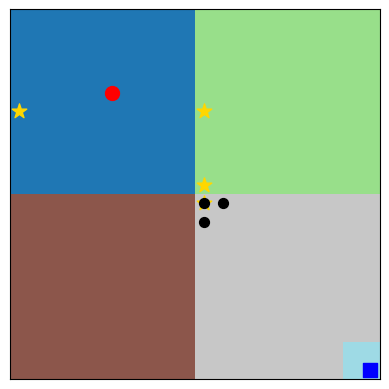

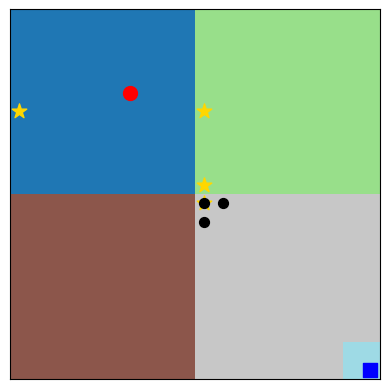

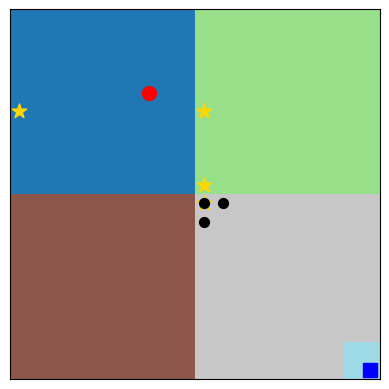

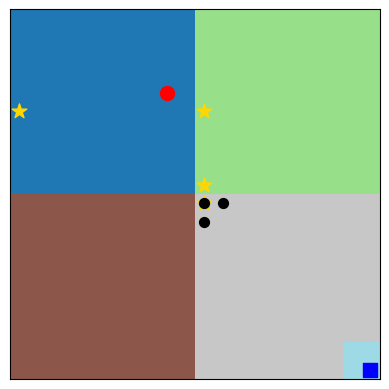

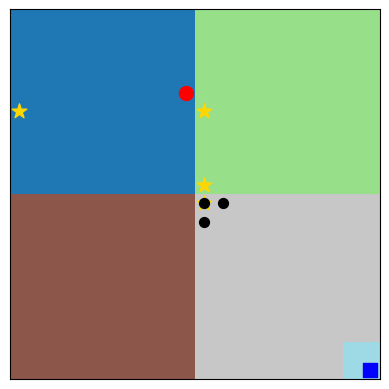

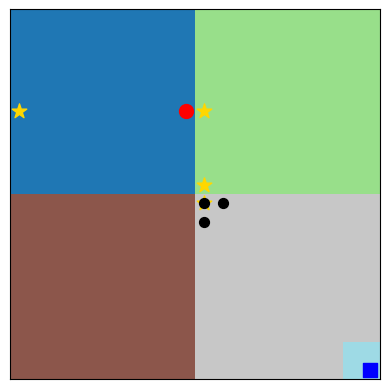

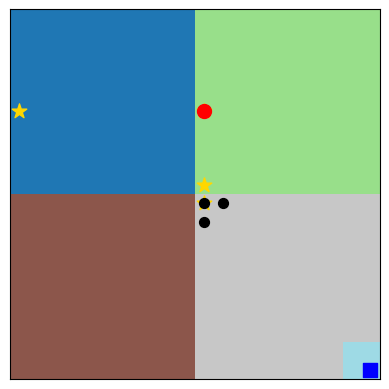

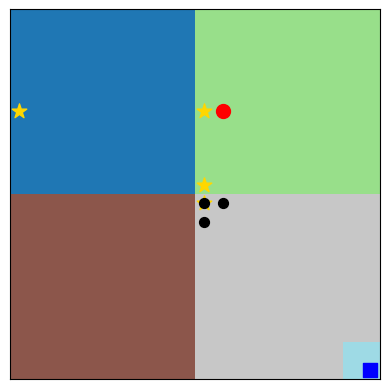

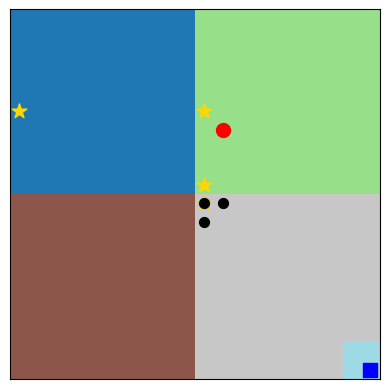

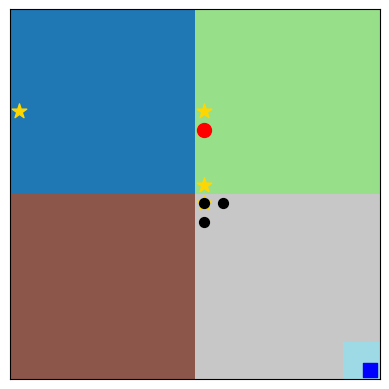

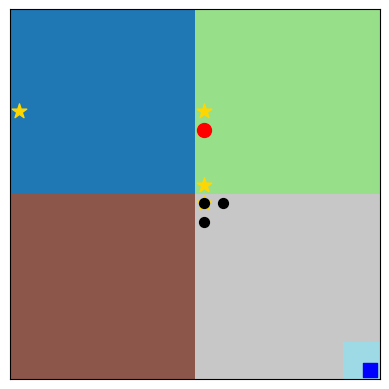

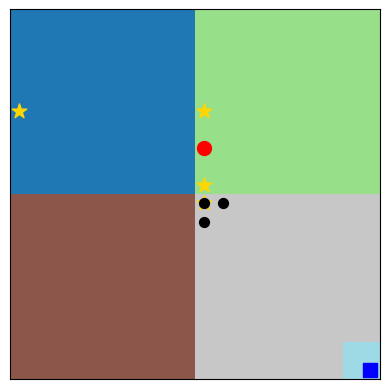

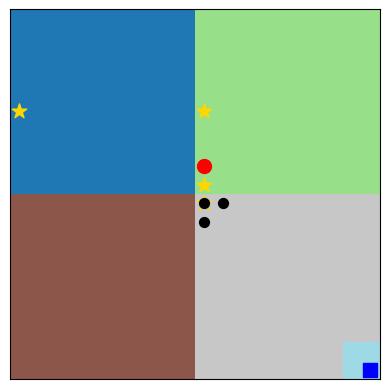

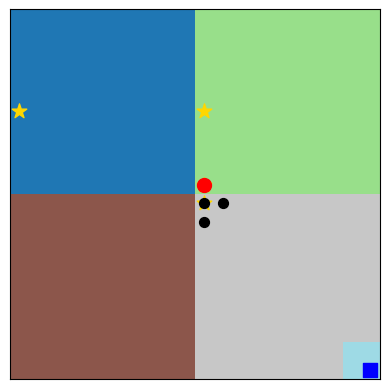

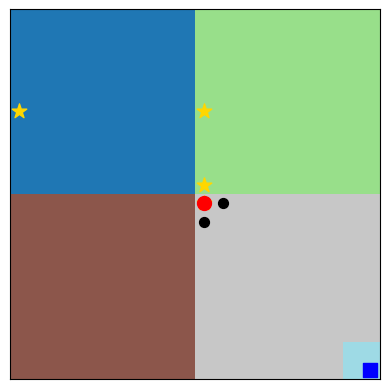

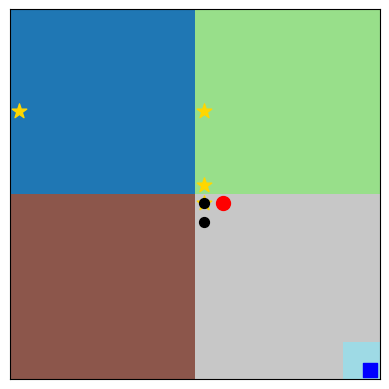

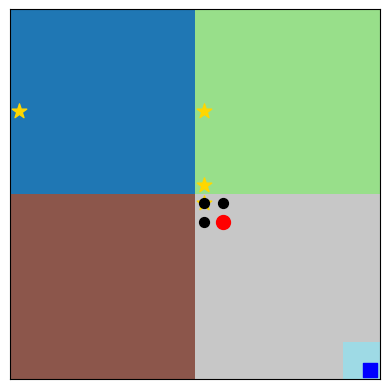

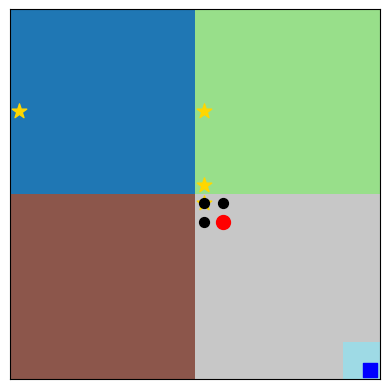

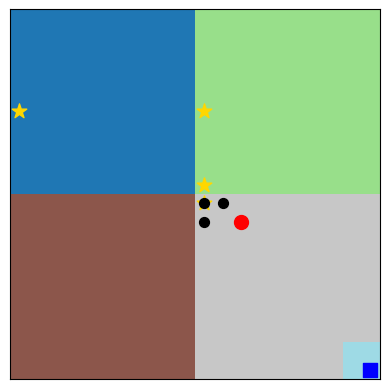

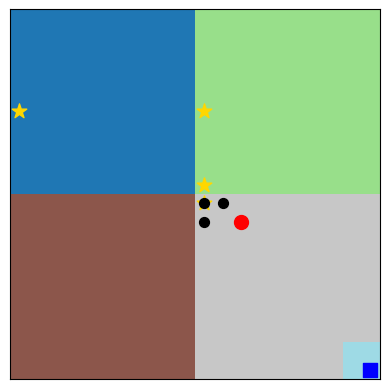

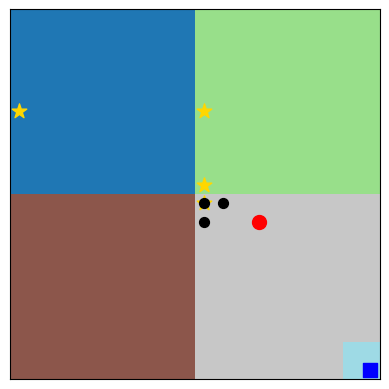

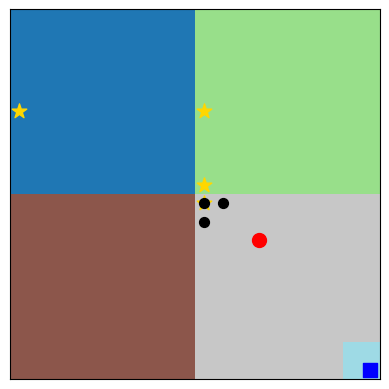

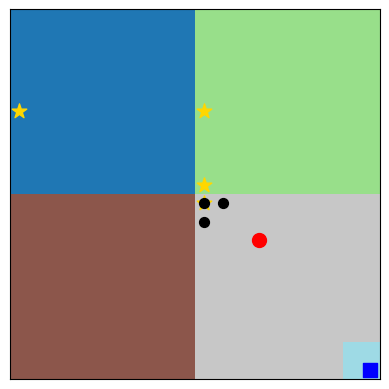

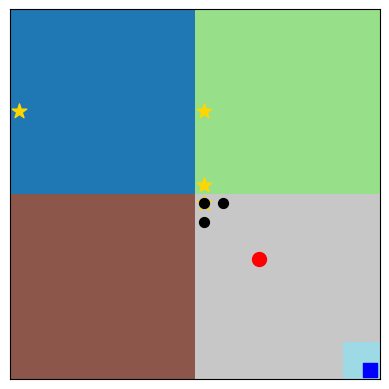

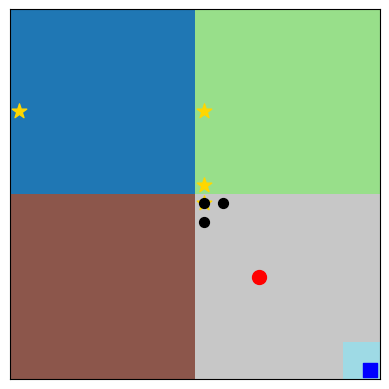

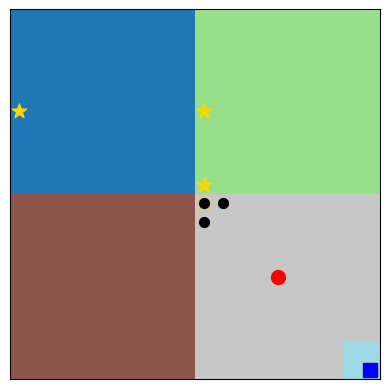

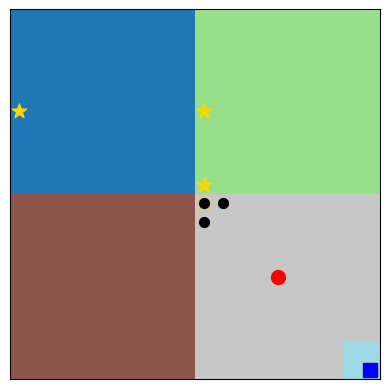

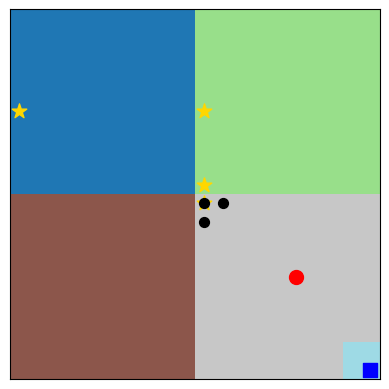

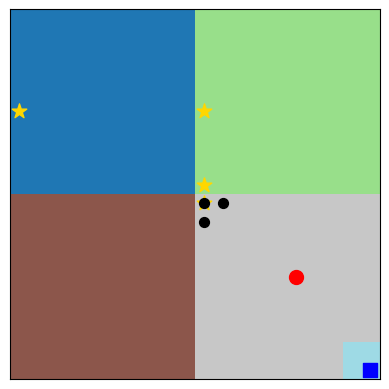

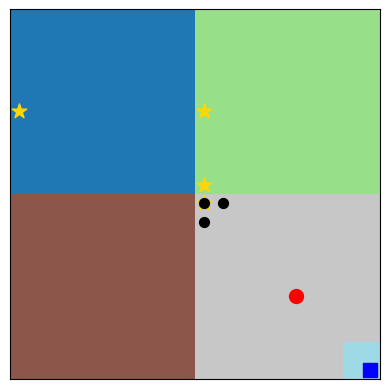

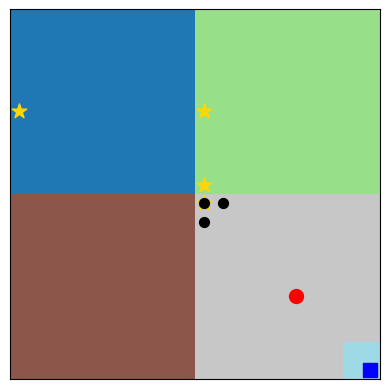

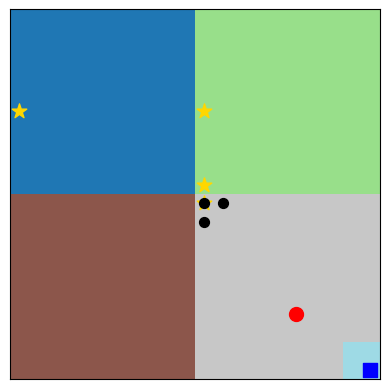

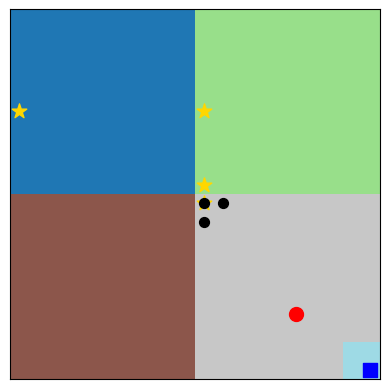

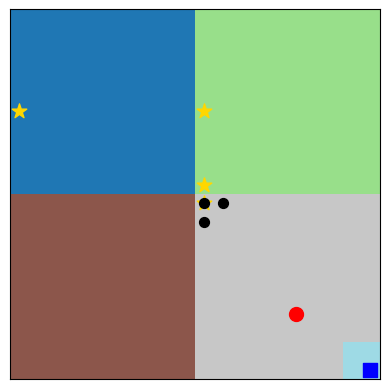

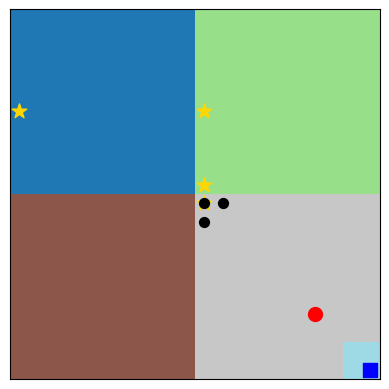

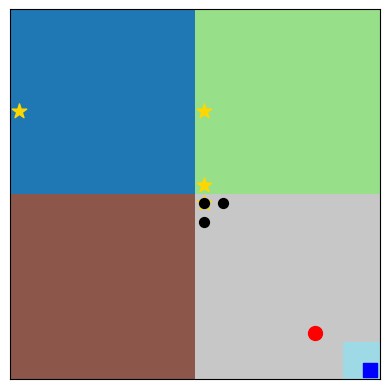

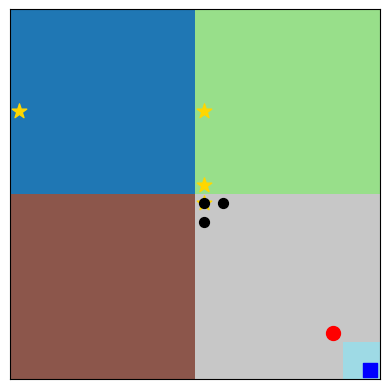

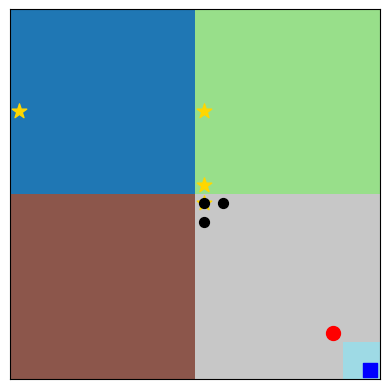

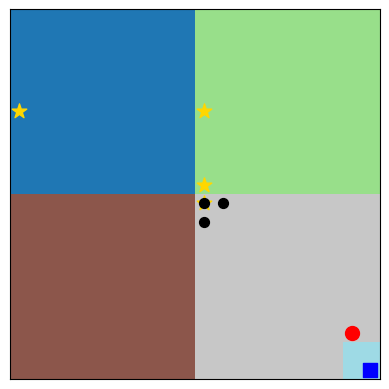

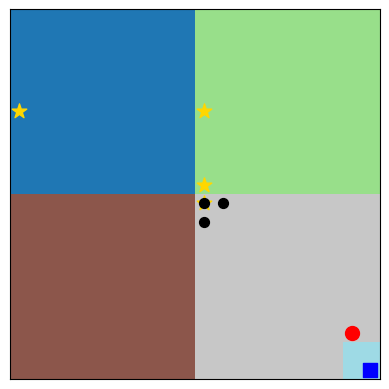

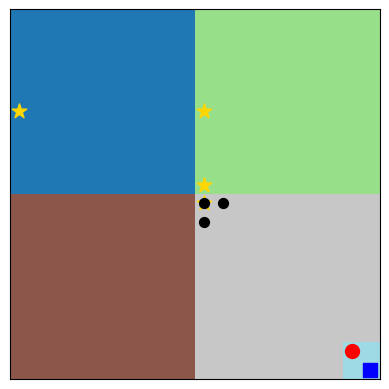

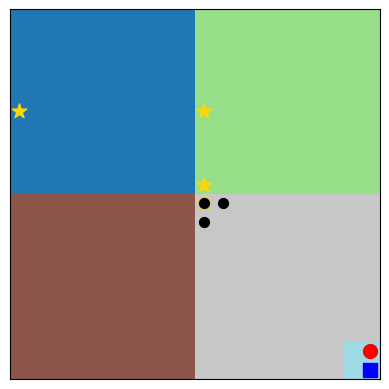

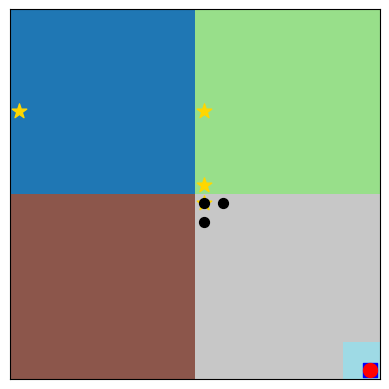

<Figure size 640x480 with 0 Axes>

In [ ]:
# MAIN
SIZE = 20
START = [0, 0]
END = [19, 19]
obstacles = [[10,10], [11,10], [10,11]]

region_grid = create_region_grid(SIZE)
treasures = create_treasures(region_grid, 5)

print("Running Value Iteration...")
flat_policy = value_iteration(SIZE, obstacles, END, treasures)

options = [
    NavigateToRegion(JUNGLE, region_grid, flat_policy),
    CollectTreasure(treasures, flat_policy),
    GoToExit(END, treasures, flat_policy)
]

hier_agent = HierarchicalAgent(options)

f = run_episode("flat", (START[0], START[1], 0), END, treasures, obstacles,
                flat_policy=flat_policy)

h = run_episode("hier", (START[0], START[1], 0), END, treasures, obstacles,
                hier_agent=hier_agent)

print("\n=== PERFORMANCE COMPARISON ===")
print(f"Flat MDP         -> Steps:{f[0]} Reward:{f[1]} Time:{f[2]:.4f}s")
print(f"Hierarchical MDP -> Steps:{h[0]} Reward:{h[1]} Time:{h[2]:.4f}s")

print("\nVisualizing Hierarchical Agent...")
plt.figure(figsize=(6,6))
run_episode("hier", (START[0], START[1], 0), END, treasures, obstacles,
            hier_agent=hier_agent, visualize=True)
plt.show()